# Active learning of an unknown demand (bonus: Altair plots)

You're about to launch your product next month, but you're not sure which prices to use.
You think the demand has a log log form:

$$ \log q = \alpha + \beta \log p + \varepsilon $$

but you're unsure of the values of $\alpha$ and $\beta$

¿What should your pricing strategy be in this case? ¿How should you go about learning about demand, but without sacrificing too much profit in the meantime?

We can distinguish between two broad types of learning: active and passive.

Passive means you're choosing the optimal price according to your beliefs each period, without thinking about how your beliefs will evolve in the future. You'll still update your beliefs if reality gives you a surprise (say, demand was much higher than what your beliefs expected), but you won't take into account how the way you choose prices affect the rate of learning.

Active means you choose the optimal price as a compromise between exploitation and exploration: do you wanna try to maximize the current profits or do you wanna explore to learn faster / make sure you get the right answer? Thus, in active learning you need to take into account not just the current profits, but also how the current price choice changes the evolution of beliefs. In practice, this involves earning a bit less profit now, but getting more in the long run.

Objective of blog post here. What am I gonna do and why is it interesting.




One way to model this problem is through dynamic programming and, more particularly, with a Bellman equation. Thus, the problem of choosing a sequence of prices under active learning can be written with:

$$V() = $$


To fully flesh out this model, I borrow the notation of Aguirregabiria & Jeon [link here](http://put.it.here)

Equations bla bla

The demand doesn't have to be this way, but we'll assume this and that

With the amazing Giovanni Ballarin (link here) we are writing a package that estimates such value functions under different settings.

First we'll import the package and get the value function and policy functions to run our simulation


Pretty Altair graph. Explain what it means

Some explanation on how to write the Altair graph




## Solve for the value and policy function

In [ ]:
!git clone https://github.com/cdagnino/LearningModels.git
!mkdir LearningModels/data


In [28]:
#If you get No module named 'src', you might need to add the folder to your system path
!python LearningModels/examples/aguirregabiria_simple.py

/Users/cd/Documents/github_reps/cdagnino.github.io/notebooks/LearningModels/examples
Computed iterate 20 with error 0.313732 in 0.066165 minutes
Computed iterate 40 with error 0.038142 in 0.066512 minutes
Computed iterate 60 with error 0.004637 in 0.068594 minutes
Final Error :  0.004637232756422804
Done 60 iterations in 4.040948482354482 minutes
saved file: 2018-10-8vfi_dict.dill


After 60 iterations we get an error of 0.004. We could let it run longer to get a smaller error, but it should be fine for our plotting purposes.

## Use the policy function to simulate

In [73]:
%matplotlib inline

import matplotlib.pyplot as plt
import dill
import numpy as np
import pandas as pd
#file_n = "2018-10-1vfi_dict.dill"  
file_n = "2018-10-8vfi_dict.dill"
with open('LearningModels/data/' + file_n, 'rb') as file:
    data_d = dill.load(file)
    
    
import sys
sys.path.append('../')
import src

lambdas = src.generate_simplex_3dims(n_per_dim=data_d['n_of_lambdas_per_dim'])
price_grid = np.linspace(data_d['min_price'], data_d['max_price'])

policy = data_d['policy']
valueF = data_d['valueF']



lambdas_ext = src.generate_simplex_3dims(n_per_dim=15) #15 should watch value f iteration
print(lambdas_ext.shape)

#Interpolate policy (level price). valueF is already a function
policyF = src.interpolate_wguess(lambdas_ext, policy)

def one_run(lambda0=np.array([0.4, 0.4, 0.2]),
                             true_beta=src.betas_transition[2],
                             dmd_σϵ=src.const.σ_ɛ+0.05, time_periods=40):
    current_lambdas = lambda0
    d = {}
    d['level_prices'] = []
    d['log_dmd'] = []
    d['valueF'] = []
    d['lambda1'] = []
    d['lambda2'] = []
    d['lambda3'] = []
    d['t'] = []


    for t in range(time_periods):
        d['t'].append(t)
        d['lambda1'].append(current_lambdas[0])
        d['lambda2'].append(current_lambdas[1])
        d['lambda3'].append(current_lambdas[2])
        d['valueF'].append(valueF(current_lambdas[:2])[0])

        #0. Choose optimal price (last action of t-1)
        level_price = policyF(current_lambdas[:2]) #Check: Is this correctly defined with the first two elements?
        d['level_prices'].append(level_price[0])

        #1. Demand happens
        log_dmd = src.draw_true_log_dmd(level_price, true_beta, dmd_σε)
        d['log_dmd'].append(log_dmd[0])

        #2. lambda updates: log_dmd: Yes, level_price: Yes
        new_lambdas = src.update_lambdas(log_dmd, src.dmd_transition_fs, current_lambdas,
                       action=level_price, old_state=1.2)

        current_lambdas = new_lambdas
            
    return pd.DataFrame(d)

def many_runs(total_runs, **kwargs):
    dfs = []
    for run in range(total_runs):
        df = one_run(**kwargs)
        df['firm_id'] = run
        dfs.append(df)
        
    return pd.concat(dfs, axis=0)

all_firms = many_runs(7, time_periods=70)




(120, 3)


## Plot with your new BFF: Altair



,level_prices,log_dmd,valueF,lambda1,lambda2,lambda3,t,run
0,0.689655,2.448822,19.774117,0.400000,0.400000,0.200000,0,0
1,0.689655,1.486705,23.097939,0.751415,0.198194,0.050391,1,0
2,0.689655,1.406272,18.486313,0.297765,0.555443,0.146793,2,0
3,1.751245,0.374592,16.663332,0.042677,0.741177,0.216146,3,0


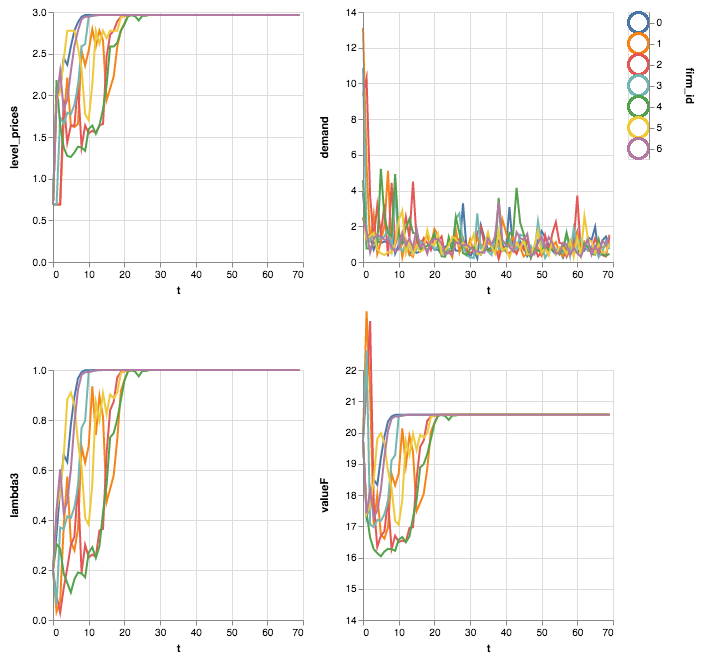

In [74]:
all_firms['demand'] = np.e**(all_firms['log_dmd'])
selector = alt.selection_single(empty='all', fields=['firm_id'], on='mouseover')

base = alt.Chart(all_firms).properties(
    width=250,
    height=250
).add_selection(selector).transform_filter(
    selector
)

color_timeseries = alt.Color('firm_id:N', legend=None)

#alt.Y('level_prices', scale=alt.Scale(domain=(0, 3.5)))
timeseries1 = base.mark_line(strokeWidth=2).encode(
    x='t',
    y=alt.Y('level_prices'),
    color=color_timeseries
)

timeseries2 = base.mark_line(strokeWidth=2).encode(
    x='t',
    y=alt.Y('demand'),
    color=color_timeseries 
)

timeseries3 = base.mark_line(strokeWidth=2).encode(
    x='t',
    y=alt.Y('lambda3'),
    color=color_timeseries 
)

timeseries4 = base.mark_line(strokeWidth=2).encode(
    x='t',
    y=alt.Y('valueF', scale=alt.Scale(domain=(14, 22))),
    color=color_timeseries 
)


color = alt.condition(selector,
                      alt.Color('firm_id:N', legend=None, ),
                      alt.value('lightgray'))


legend = alt.Chart(all_firms).mark_point(size=400).encode(
    y=alt.Y('firm_id:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selector
)


(timeseries1 | timeseries2) & (timeseries3 | timeseries4) | legend

In [ ]:
df = one_run()
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

xmax = 100
ax1, ax2, ax3, ax4 = axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]
for run in todo.run.unique():
    df = todo[todo.run == run]
    
    df.lambda3.plot(ax=ax1)
    ax1.set_xlabel("Time periods", size=14)
    ax1.set_title("Evolution of value of true lambda", size=16)

    df.valueF.plot(ax=ax2)
    ax2.set_xlabel("Time periods", size=14)
    ax2.set_title("Value Function", size=16)

    df.level_prices.plot(ax=ax3)
    ax3.set_xlabel("Time periods", size=14)
    ax3.set_title("Price", size=16)

    df.log_dmd.plot(ax=ax4)
    ax4.set_xlabel("Time periods", size=14)
    ax4.set_title("Demand", size=16)
    
    ax4.set_xlim(0, xmax)
    fig.tight_layout()

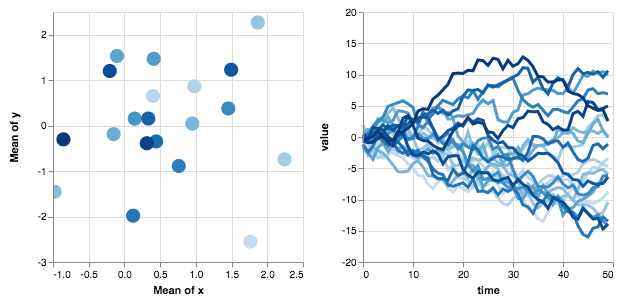

In [29]:
import altair as alt
#Only for notebook: alt.renderers.enable('notebook')
import pandas as pd
import numpy as np

np.random.seed(0)

n_objects = 20
n_times = 50

# Create one (x, y) pair of metadata per object
locations = pd.DataFrame({
    'id': range(n_objects),
    'x': np.random.randn(n_objects),
    'y': np.random.randn(n_objects)
})

# Create a 50-element time-series for each object
timeseries = pd.DataFrame(np.random.randn(n_times, n_objects).cumsum(0),
                          columns=locations['id'],
                          index=pd.RangeIndex(0, n_times, name='time'))

# Melt the wide-form timeseries into a long-form view
timeseries = timeseries.reset_index().melt('time')

# Merge the (x, y) metadata into the long-form view
timeseries['id'] = timeseries['id'].astype(int)  # make merge not complain
data = pd.merge(timeseries, locations, on='id')

# Data is prepared, now make a chart

selector = alt.selection_single(empty='all', fields=['id'], on='mouseover')

base = alt.Chart(data).properties(
    width=250,
    height=250
).add_selection(selector)

points = base.mark_point(filled=True, size=200).encode(
    x='mean(x)',
    y='mean(y)',
    color=alt.condition(selector, 'id:O', alt.value('lightgray'), legend=None),
).interactive()

timeseries = base.mark_line(strokeWidth=3).encode(
    x='time',
    y=alt.Y('value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
)

points | timeseries

In [32]:
data.head(4)

,time,id,value,x,y,other_value
0,0,0,-1.048553,1.764052,-2.55299,7.297701
1,1,0,-1.721013,1.764052,-2.55299,-0.211067
2,2,0,-2.886163,1.764052,-2.55299,0.154619
3,3,0,-1.003013,1.764052,-2.55299,4.571799


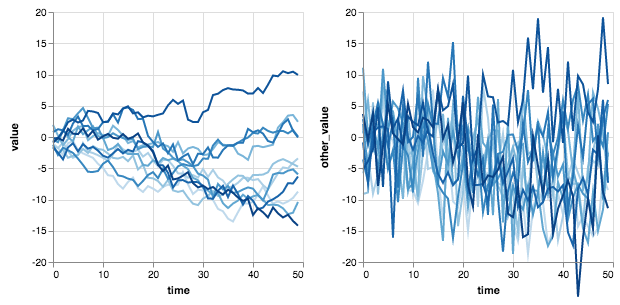

In [30]:
data['other_value'] = data['value'] + np.random.normal(0, 5, size=len(data))
data = data[data.id < 11]

selector = alt.selection_single(empty='all', fields=['id'], on='mouseover')

base = alt.Chart(data).properties(
    width=250,
    height=250
).add_selection(selector)


timeseries1 = base.mark_line(strokeWidth=2).encode(
    x='time',
    y=alt.Y('value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
)

timeseries2 = base.mark_line(strokeWidth=2).encode(
    x='time',
    y=alt.Y('other_value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:O', legend=None) 
).transform_filter(
    selector
)


timeseries1 | timeseries2 

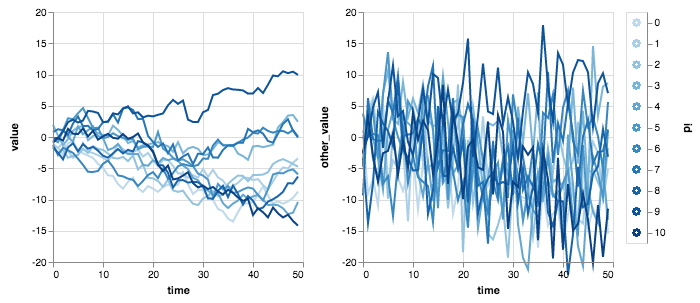

In [8]:
data['other_value'] = data['value'] + np.random.normal(0, 5, size=len(data))
data = data[data.id < 11]

selector = alt.selection_single(empty='all', fields=['id'], on='mouseover')

base = alt.Chart(data).properties(
    width=250,
    height=250
).add_selection(selector)


timeseries1 = base.mark_line(strokeWidth=2).encode(
    x='time',
    y=alt.Y('value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:O', legend=None)
).transform_filter(
    selector
)

timeseries2 = base.mark_line(strokeWidth=2).encode(
    x='time',
    y=alt.Y('other_value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:O', legend=None) 
).transform_filter(
    selector
)

color = alt.condition(selector,
                      alt.Color('id:O', legend=None),
                      alt.value('lightgray'))


legend = alt.Chart(data).mark_point().encode(
    y=alt.Y('id:O', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selector
)

timeseries1 | timeseries2 | legend

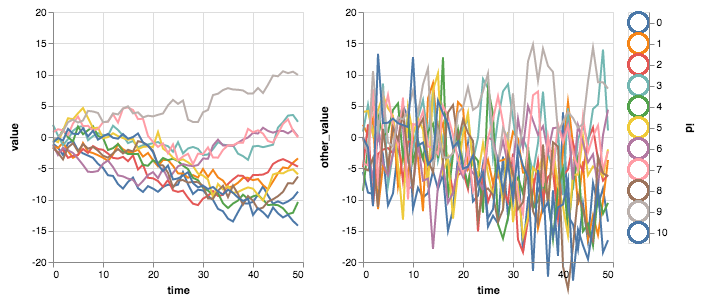

In [13]:
data['other_value'] = data['value'] + np.random.normal(0, 5, size=len(data))
data = data[data.id < 11]

selector = alt.selection_single(empty='all', fields=['id'], on='click')

base = alt.Chart(data).properties(
    width=250,
    height=250
).add_selection(selector)


timeseries1 = base.mark_line(strokeWidth=2).encode(
    x='time',
    y=alt.Y('value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:N', legend=None)
).transform_filter(
    selector
)

timeseries2 = base.mark_line(strokeWidth=2).encode(
    x='time',
    y=alt.Y('other_value', scale=alt.Scale(domain=(-15, 15))),
    color=alt.Color('id:N', legend=None) 
).transform_filter(
    selector
)

color = alt.condition(selector,
                      alt.Color('id:N', legend=None, ),
                      alt.value('lightgray'))


legend = alt.Chart(data).mark_point(size=400).encode(
    y=alt.Y('id:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selector
)

timeseries1 | timeseries2 | legend